In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

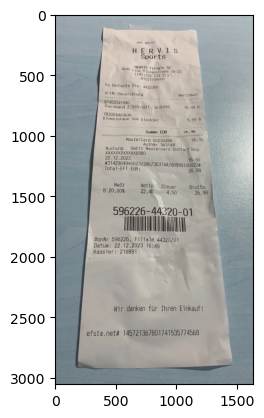

In [4]:
img = cv2.imread("data/test.jpg")
plt.imshow(img)
plt.show()

# 1. Morphological Operation

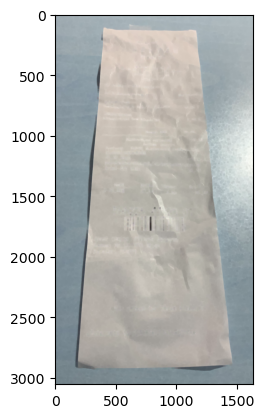

In [5]:
# Repeated Closing operation to remove text from the document.
kernel = np.ones((5,5),np.uint8)
whiteBill = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
plt.imshow(whiteBill)

# 2.Magic of GrabCut

In [6]:
mask = np.zeros(whiteBill.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
bgdModel

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]])

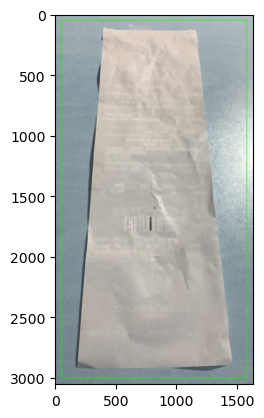

In [7]:
pad = 50
rect = (pad,pad,whiteBill.shape[1]-2*pad,whiteBill.shape[0]-2*pad)
whiteBill

imgRect = cv2.rectangle(whiteBill,rect,(0,255,0),3)
plt.imshow(imgRect)

In [8]:
(mask, bgModel, fgModel) = cv2.grabCut(
    whiteBill, mask, rect, bgdModel, fgdModel,
    iterCount=5,mode=cv2.GC_INIT_WITH_RECT)

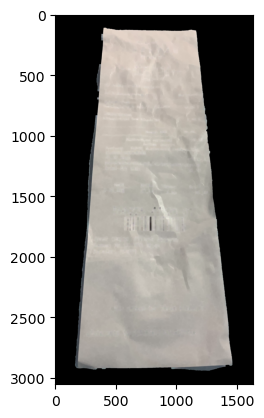

In [9]:
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
whiteBill = whiteBill*mask2[:,:,np.newaxis]

plt.imshow(whiteBill)

# 3.Edge Detectin and Contour Detection

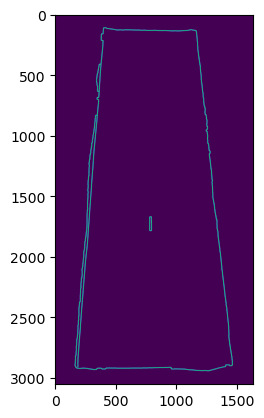

In [10]:
gray = cv2.cvtColor(whiteBill, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (11, 11), 0)
# Edge Detection.
canny = cv2.Canny(gray, 0, 200)
canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

plt.imshow(canny)


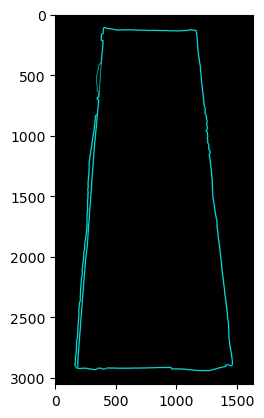

In [11]:
# Blank canvas.
con = np.zeros_like(whiteBill)
# Finding contours for the detected edges.
contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Keeping only the largest detected contour.
page = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
con = cv2.drawContours(con, page, -1, (0, 255, 255), 3)
plt.imshow(con)

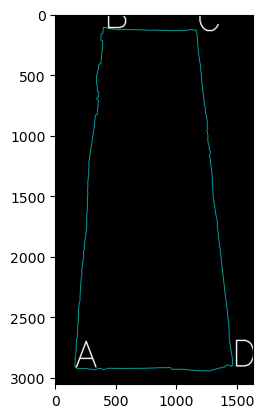

In [12]:
# Blank canvas.
con = np.zeros_like(whiteBill)
# Loop over the contours.
for c in page:
  # Approximate the contour.
  epsilon = 0.02 * cv2.arcLength(c, True)
  corners = cv2.approxPolyDP(c, epsilon, True)
  # If our approximated contour has four points
  if len(corners) == 4:
      break
cv2.drawContours(con, c, -1, (0, 255, 255), 3)
cv2.drawContours(con, corners, -1, (0, 255, 0), 10)
# Sorting the corners and converting them to desired shape.
corners = sorted(np.concatenate(corners).tolist())
 
# Displaying the corners.
for index, c in enumerate(corners):
  character = chr(65 + index)
  cv2.putText(con, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 10, (255, 255, 255), 10, cv2.LINE_AA)

plt.imshow(con)

In [13]:
def order_points(pts):
    '''Rearrange coordinates to order:
      top-left, bottom-left, bottom-right, top-right'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]
 
    diff = np.diff(pts, axis=1)
    # Bottom-left will have the largest difference.
    rect[1] = pts[np.argmax(diff)]
    # Top-right point will have the smallest difference.
    rect[3] = pts[np.argmin(diff)]
    # Return the ordered coordinates.
    return rect.astype('int').tolist()

In [14]:
pts = order_points(corners)
(tl, bl, br, tr) = pts
# Finding the maximum width.
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))
# Finding the maximum height.
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))
# Final destination co-ordinates.
destination_corners = [[0, 0], [0, maxHeight], [maxWidth, maxHeight], [maxWidth, 0]]


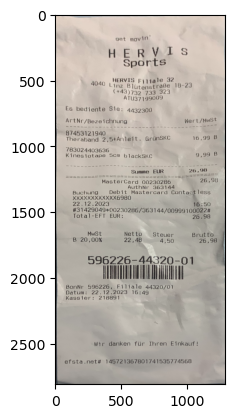

In [15]:
# Getting the homography.
M = cv2.getPerspectiveTransform(np.float32(pts), np.float32(destination_corners))
# Perspective transform using homography.
final = cv2.warpPerspective(img, M, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LINEAR)
plt.imshow(final)

In [17]:
cv2.imwrite("data/hervis.jpg", final)

True